### Rescaling velocities to match desired temperature

Using Verlet's units, we have

$$
  T = 16 \sum_{i} \frac{v_{i}^{2}}{N}.
$$

Using the notation $T_{i}$ for the temperature of the $i^{th}$ particle,

$$
  T_{i} = 16 v_{i}^{2}
$$

and

$$
  T = \langle T_{i} \rangle.
$$

We want to rescale the velocities $\{ v_{i} \}$. Define the set of rescaled temperatures $\{ \tilde{T}_{i} \}$ such that

$$
  \langle \tilde{T}_{i} \rangle \equiv T_{desired}.
$$

To find the relationship between $\{ \tilde{T}_{i} \}$ and $\{ T_{i} \}$, note that

$$
  T_{desired} = \bigg( \frac{T_{desired}}{T} \bigg) T
  = \bigg( \frac{T_{desired}}{T} \bigg) \langle T_{i} \rangle
  = \bigg \langle \frac{T_{desired}}{T} T_{i} \bigg \rangle
$$

giving

$$
  \tilde{T}_{i} = \frac{T_{desired}}{T} T_{i}
$$

as a valid rescaling of $T$, with which we can calculate the velocity rescaling $\tilde{v}_{i}$ as

$$
  \tilde{v}_{i} = \sqrt{ \frac{T_{desired}}{T} } v_{i}.
$$

### Load Molecular Dynamics Trial class and associated save/load/comparator/etc. methods

In [56]:
include("../common/md/md.jl")

relaxaggresively! (generic function with 2 methods)

In [15]:
import Gadfly

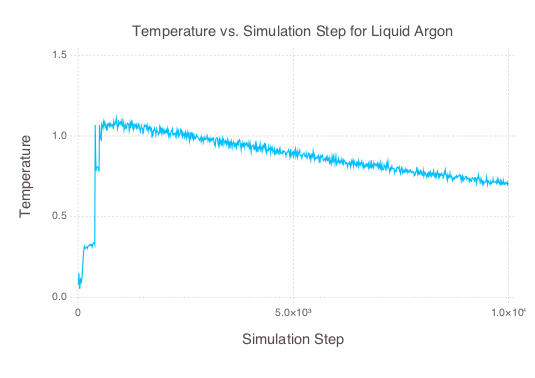

In [117]:
p = loadmdtrial("q2/p");
temps = Gadfly.plot( x=[10:10:10000], y=p.T[10:10:10000], Gadfly.Geom.line,
Gadfly.Guide.xlabel("Simulation Step"), Gadfly.Guide.ylabel("Temperature"),
Gadfly.Guide.title("Temperature vs. Simulation Step for Liquid Argon"))

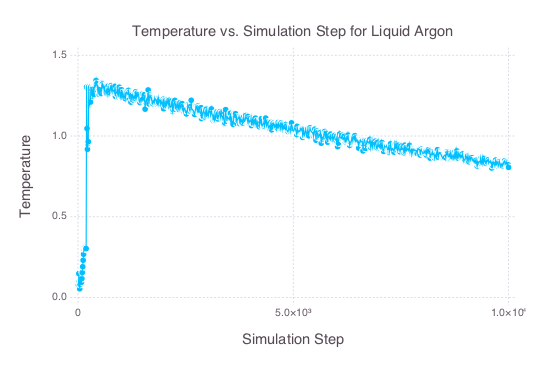

In [129]:
q = loadmdtrial("q2/q");
temps2 = Gadfly.plot( x=[10:10:q.currentStep], y=q.T[10:10:q.currentStep], Gadfly.Geom.line, Gadfly.Geom.point,
Gadfly.Guide.xlabel("Simulation Step"), Gadfly.Guide.ylabel("Temperature"),
Gadfly.Guide.title("Temperature vs. Simulation Step for Liquid Argon"))

It seems that my mdplace! algorithm leads to a relatively low equilibrium temperature (which is unsurprising, given that it provides a large inter-atomic distance and a high degree of symmetry). Thermalization seems to have occured by the 200th step.

Much more horribly, there seems to be a severe energy leak, which I traced back to a faulty method for enforcing the periodic boundary conditions.

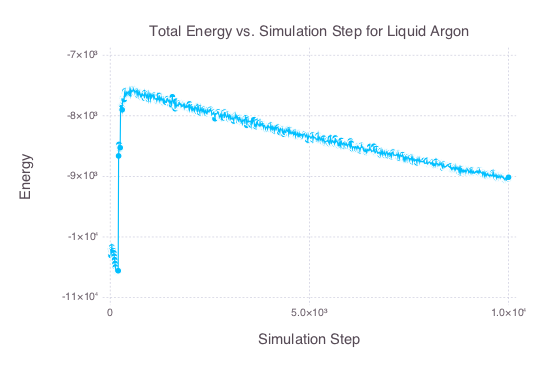

In [130]:
energies = Gadfly.plot( x=[10:10:q.currentStep], y=q.e[10:10:q.currentStep], Gadfly.Geom.line, Gadfly.Geom.point,
Gadfly.Guide.xlabel("Simulation Step"), Gadfly.Guide.ylabel("Energy"),
Gadfly.Guide.title("Total Energy vs. Simulation Step for Liquid Argon") )

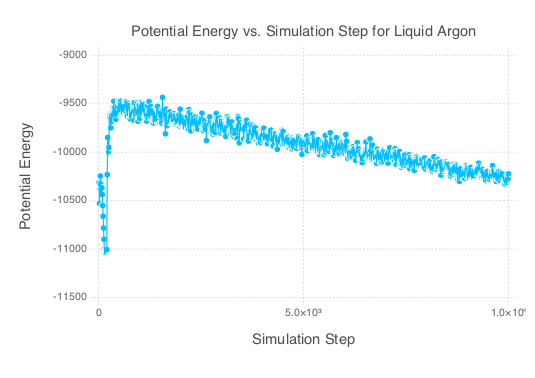

In [131]:
pe = Gadfly.plot( x=[10:10:q.currentStep], y=q.pet[10:10:q.currentStep], Gadfly.Geom.line, Gadfly.Geom.point,
Gadfly.Guide.xlabel("Simulation Step"), Gadfly.Guide.ylabel("Potential Energy"),
Gadfly.Guide.title("Potential Energy vs. Simulation Step for Liquid Argon") )

Here's what the corrected (and vastly speedier) potential energy algorithm looks like:

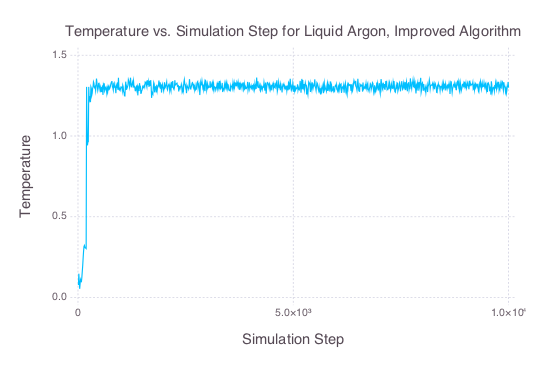

In [134]:
r = loadmdtrial("q2/r");
temps_fixed = Gadfly.plot( x=[10:10:r.currentStep], y=r.T[10:10:r.currentStep], Gadfly.Geom.line,
Gadfly.Guide.xlabel("Simulation Step"), Gadfly.Guide.ylabel("Temperature"),
Gadfly.Guide.title("Temperature vs. Simulation Step for Liquid Argon, Improved Algorithm"))

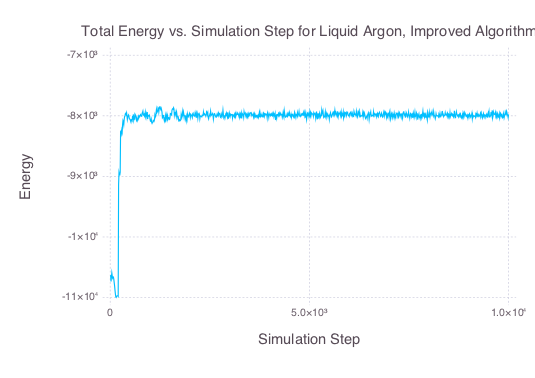

In [135]:
e_fixed = Gadfly.plot( x=[10:10:r.currentStep], y=r.e[10:10:r.currentStep], Gadfly.Geom.line,
Gadfly.Guide.xlabel("Simulation Step"), Gadfly.Guide.ylabel("Energy"),
Gadfly.Guide.title("Total Energy vs. Simulation Step for Liquid Argon, Improved Algorithm"))